In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import rasterio as rio
import numpy as np
import pandas as pd

/home/jlauner/.conda/envs/jw4a-d2.1/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


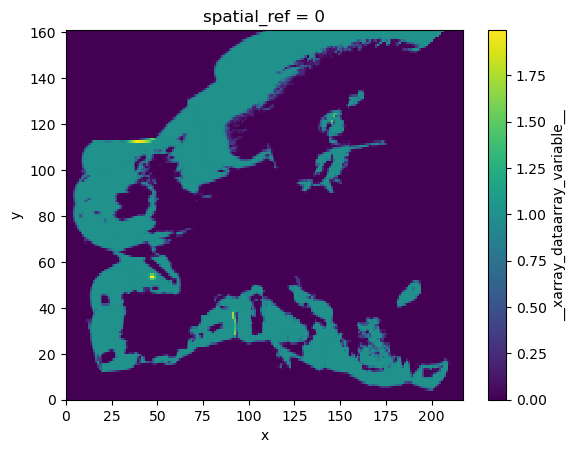

In [2]:
path_availability_deep = "../build/availability/availability_offshore_deep.nc"
avalability_deep = rioxarray.open_rasterio(path_availability_deep)
avalability_deep = avalability_deep.rio.set_spatial_dims(x_dim="x", y_dim="y")
avalability_deep.sum("id").squeeze(drop=True).squeeze(drop=True).plot()

Why does the above map show some pixels with values larger than 1? Shouldn't the values be between 0 and 1? Probably because of overlapping regions.

Next, I aim to generate a sub-eez segmentation of the EEZ. I try to re-use a function from pypsa/fresna to generate voronoi patterns within the EEZ, with representative points at the coast as centers.

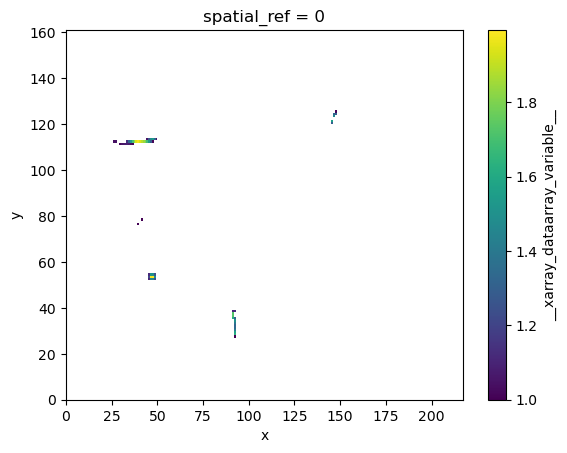

In [3]:
# get locations where availability > 1
a = avalability_deep.sum("id").squeeze(drop=True).squeeze(drop=True)
# a.where((a<=1)&(a>0)).plot()
a.where((a>1)&(a>0)).plot()

In [4]:
path_boundaries_eez = "../build/shapes/eez.geojson"
path_boundaries_onshore = "../data/europe-98-zones.geojson/europe-98-zones.geojson"

eez = gpd.read_file(path_boundaries_eez)
ehighways = gpd.read_file(path_boundaries_onshore)

In [6]:
crs = ehighways.crs
ehighways_union = gpd.GeoDataFrame(geometry=[ehighways.unary_union], crs=crs)
# before buffering, tranform to ETRS89 Lambert Azimuthal Equal Area CRS
# ehighways_union = ehighways_union.to_crs("3035").buffer(100).to_crs(crs)
ehighways_union_boundary = ehighways_union.boundary


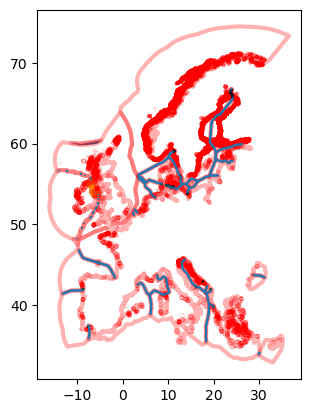

In [7]:
def find_intersections(gdf):
    sindex = gdf.sindex
    # Create an empty GeoDataFrame to store the intersections
    intersections = []
    # Iterate over each geometry in the GeoDataFrame
    for idx, geometry in gdf['geometry'].items():
        # Find potential intersections using spatial index
        possible_matches_index = list(sindex.intersection(geometry.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        
        # Filter out the actual intersections
        intersections_temp = possible_matches[possible_matches.intersects(geometry)]
        
        # Remove self-intersections
        intersections_temp = intersections_temp[intersections_temp.index != idx]
        
        # Perform intersection operation and append to the result GeoDataFrame
        intersections.append(
            intersections_temp.intersection(geometry)
        )

    # Display the result
    return intersections


intersections = find_intersections(eez)


fig, ax = plt.subplots()
eez.boundary.plot(ax=ax, color="red", linewidth=3, alpha=0.3)
for i in intersections:
    i.plot(ax=ax)

In [8]:
def get_boundaries_outside(gdf):
    r""""
    
    """
    gdf_union_boundary = gpd.GeoDataFrame(geometry=[gdf.unary_union], crs=gdf.crs).boundary
    index_name = gdf.index.name

    boundaries_outside = []
    for id, row in gdf.iterrows():
        boundary_outside = row.geometry.intersection(gdf_union_boundary)
        geometry = boundary_outside.geometry.item()

        new_row = row.copy()
        new_row[index_name] = id
        new_row["geometry"] = geometry
        boundaries_outside.append(new_row)


    boundaries_outside = gpd.GeoDataFrame(boundaries_outside).set_index(index_name)
    return boundaries_outside

boundaries_outside = get_boundaries_outside(ehighways)
boundaries_outside

,id,country_code,name,type,proper,geometry
0,ALB_1,ALB,Albania,country,True,"MULTILINESTRING ((19.99213 39.77490, 19.99181 ..."
1,AUT_1,AUT,custom_region,custom_region,True,"MULTILINESTRING ((9.60704 47.06077, 9.61180 47..."
2,AUT_2,AUT,custom_region,custom_region,True,LINESTRING Z EMPTY
3,AUT_3,AUT,custom_region,custom_region,True,LINESTRING Z EMPTY
4,BEL_1,BEL,Belgium,country,True,"MULTILINESTRING ((2.54545 51.08905, 2.54601 51..."
...,...,...,...,...,...,...
93,SVN_1,SVN,Slovenia,country,True,"MULTILINESTRING ((13.58307 45.47741, 13.58506 ..."
94,SWE_1,SWE,custom_region,custom_region,True,"MULTILINESTRING ((21.60959 65.09620, 21.60888 ..."
95,SWE_2,SWE,custom_region,custom_region,True,"MULTILINESTRING ((17.32378 60.68683, 17.32388 ..."
96,SWE_3,SWE,custom_region,custom_region,True,"MULTILINESTRING ((18.16225 57.31538, 18.16365 ..."


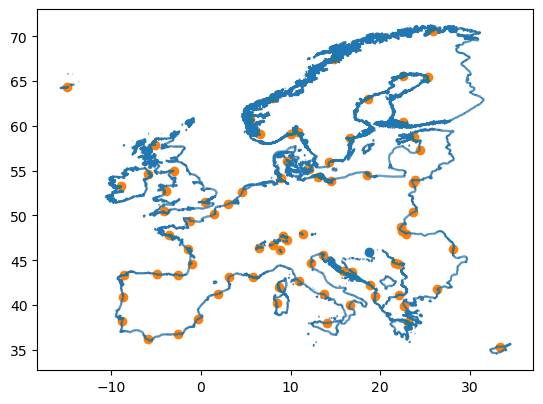

In [9]:
fig, ax = plt.subplots()
boundaries_outside.geometry.plot(ax=ax)
boundaries_outside.geometry.representative_point().plot(ax=ax)
plt.show()

In [10]:
from scipy.spatial import Voronoi
from shapely import Polygon


def voronoi_partition_pts_from_gdf(points, outline, no_multipolygons=False):
    if isinstance(points, gpd.GeoSeries):
        point_array = [[point.x, point.y] for point in points]
    elif isinstance(points, gpd.GeoDataFrame):
        point_array = [[point.geometry.x, point.geometry.y] for point in points]
    
    voronoi = voronoi_partition_pts(point_array, outline, no_multipolygons=False)

    voronoi_gdf = gpd.GeoDataFrame({"id": points.index, "geometry": voronoi}).set_index("id")

    return voronoi_gdf
    


def voronoi_partition_pts(points, outline, no_multipolygons=False):
    """
    Compute the polygons of a voronoi partition of `points` within the
    polygon `outline`

    Attributes
    ----------
    points : Nx2 - ndarray[dtype=float]
    outline : Polygon
    no_multipolygons : bool (default: False)
        If true, replace each MultiPolygon by its largest component

    Returns
    -------
    polygons : list[dtype=Polygon|MultiPolygon]
    """

    points = np.asarray(points)

    if len(points) == 1:
        polygons = [outline]
    else:
        xmin, ymin = np.amin(points, axis=0)
        xmax, ymax = np.amax(points, axis=0)
        xspan = xmax - xmin
        yspan = ymax - ymin

        # to avoid any network positions outside all Voronoi cells, append
        # the corners of a rectangle framing these points
        vor = Voronoi(np.vstack((points,
                                 [[xmin-10.*xspan, ymin-10.*yspan],
                                  [xmin-10.*xspan, ymax+10.*yspan],
                                  [xmax+10.*xspan, ymin-10.*yspan],
                                  [xmax+10.*xspan, ymax+10.*yspan]])))

        polygons = []
        for i in range(len(points)):
            poly = Polygon(vor.vertices[vor.regions[vor.point_region[i]]])

            if not poly.is_valid:
                poly = poly.buffer(0)

            poly = poly.intersection(outline)

            polygons.append(poly)
    
    return polygons

In [11]:
unique_ehigh = sorted(ehighways.country_code.unique())
unique_eez = sorted(eez.iso_ter1.unique())

# does each eez belong to a country in ehighways?
missing_in_ehighways =  set(unique_eez) - set(unique_ehigh)
missing_in_eez = set(unique_ehigh) - set(unique_eez)
print(f"Country in EEZ which is missing ehighways: {missing_in_ehighways}")
print(f"Country in ehighways which is missing in eez: {missing_in_eez}")
# TODO: ISL Iceland's EEZ is missing!

Country in EEZ which is missing ehighways: set()
Country in ehighways which is missing in eez: {'CZE', 'SVK', 'SRB', 'ISL', 'MKD', 'HUN', 'CHE', 'LUX', 'AUT'}


In [12]:
# Here, I produce a GeoDataFrame with an id of the connected onshore region, which eez it belongs to, geometry of the voronoi within the eez
points = gpd.GeoDataFrame(geometry=boundaries_outside.geometry.representative_point())
points = points.join(boundaries_outside.drop("geometry", axis=1))
points = points.loc[points.is_empty == False]
points

,geometry,id,country_code,name,type,proper
0,POINT (19.47766 40.97152),ALB_1,ALB,Albania,country,True
1,POINT (9.56698 47.24239),AUT_1,AUT,custom_region,custom_region,True
4,POINT (3.03841 51.28227),BEL_1,BEL,Belgium,country,True
5,POINT (26.36906 41.82068),BGR_1,BGR,Bulgaria,country,True
6,POINT (16.89911 43.70251),BIH_1,BIH,Bosnia and Herzegovina,country,True
...,...,...,...,...,...,...
93,POINT (13.65948 45.54192),SVN_1,SVN,Slovenia,country,True
94,POINT (22.56996 65.57637),SWE_1,SWE,custom_region,custom_region,True
95,POINT (18.65438 62.98462),SWE_2,SWE,custom_region,custom_region,True
96,POINT (16.63244 58.63747),SWE_3,SWE,custom_region,custom_region,True


In [13]:

zone_partitions = []
for id, data_eez in eez.iterrows():
    # TODO here I should only pass the points belonging to the state of the eez
    points_belonging_to_country = points.loc[points["country_code"] == data_eez["iso_ter1"]]
    zone_partition = voronoi_partition_pts_from_gdf(points_belonging_to_country.geometry, data_eez.geometry)
    zone_partition = zone_partition.loc[zone_partition.geometry.is_empty == False]
    zone_partition["id_eez"] = id
    zone_partitions.append(zone_partition)

zone_partitions = pd.concat(zone_partitions)


<Axes: >

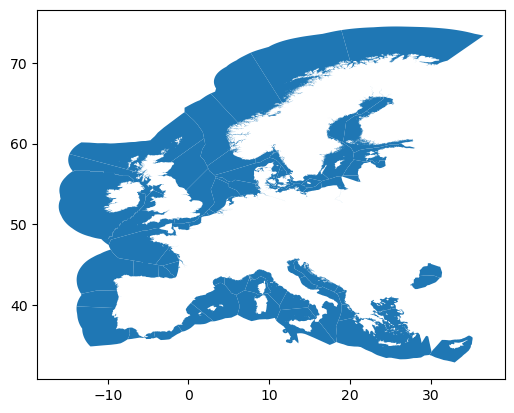

In [14]:
zone_partitions.plot()

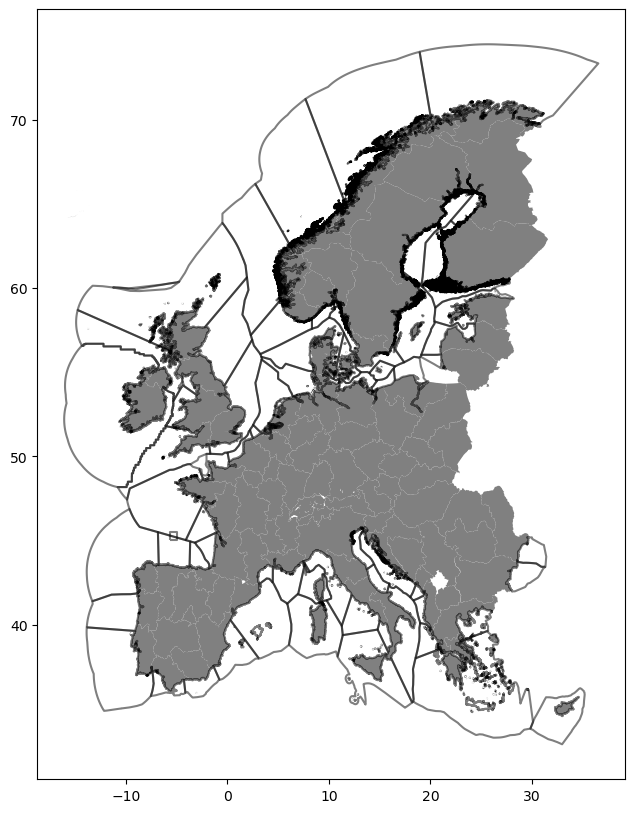

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
zone_partitions.boundary.plot(ax=ax, color="black", alpha=0.5)
# eez.boundary.plot(ax=ax, color="blue", alpha=0.5, linewidth=4)
ehighways.plot(ax=ax, color="grey")
# boundaries_outside.geometry.representative_point().plot(ax=ax, color="red", alpha=0.5)
plt.show()



In [16]:
# get random colors for the 98 ehighways regions
def get_random_rgb(length=None):
    if not length:
        return tuple(np.random.choice(range(256), size=3)/256)
    else:
        return [tuple(np.random.choice(range(256), size=3)/256) for _ in range(length)] 

colors = get_random_rgb(3)
colors

[(0.7421875, 0.54296875, 0.15625),
 (0.94140625, 0.171875, 0.3671875),
 (0.6015625, 0.95703125, 0.53515625)]

In [17]:
colors = ehighways.copy()[["id"]]
colors.loc[:, "color"] = get_random_rgb(len(colors))
colors

,id,color
0,ALB_1,"(0.22265625, 0.70703125, 0.375)"
1,AUT_1,"(0.1953125, 0.63671875, 0.20703125)"
2,AUT_2,"(0.25390625, 0.27734375, 0.1875)"
3,AUT_3,"(0.39453125, 0.6640625, 0.8828125)"
4,BEL_1,"(0.91015625, 0.8125, 0.13671875)"
...,...,...
93,SVN_1,"(0.1015625, 0.1640625, 0.265625)"
94,SWE_1,"(0.94140625, 0.4140625, 0.5390625)"
95,SWE_2,"(0.0, 0.09765625, 0.2734375)"
96,SWE_3,"(0.73046875, 0.71484375, 0.96484375)"


In [18]:
ehighways["color"] = colors["color"]

In [19]:

zone_partitions_colors = zone_partitions.join(colors).color

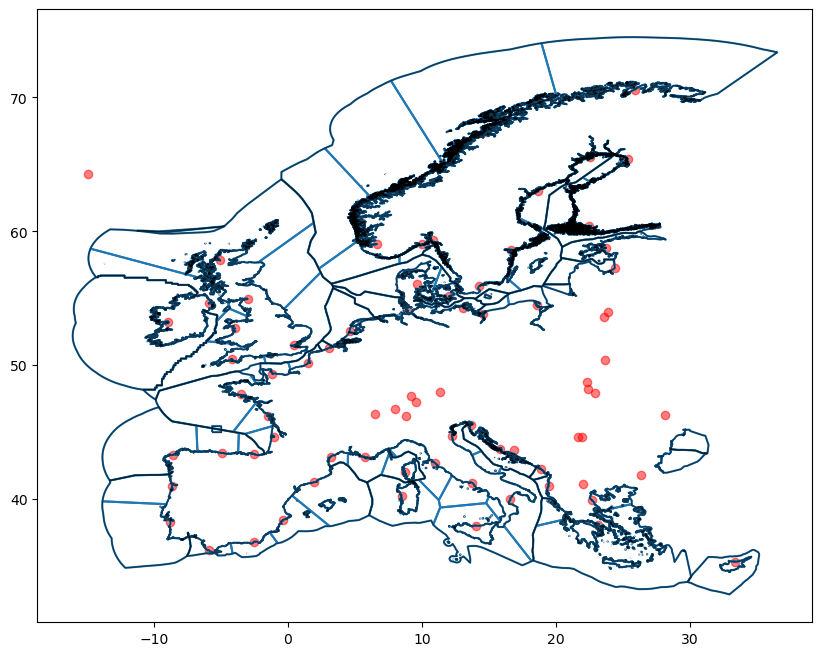

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
zone_partitions.boundary.plot(ax=ax)
eez.boundary.plot(ax=ax, color="black", alpha=0.5, linewidth=1)
# ehighways.plot(ax=ax, color=ehighways["color"])
boundaries_outside.geometry.representative_point().plot(ax=ax, color="red", alpha=0.5)
plt.show()

In [26]:
zone_partitions.to_file("zone_partitions.geojson", driver="GeoJSON")